In [20]:
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img

In [21]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2024-12-18 18:11:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-12-18 18:11:38--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  23.6MB/s    in 31s     

2024-12-18 18:12:10 (24.1 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]



In [22]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-12-18 18:12:10--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/annotations.tar.gz [following]
--2024-12-18 18:12:11--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz.1’

annotations.tar.gz. 100%[===================>]  18.28M  8.84MB/s    in 2.1s    

2024-12-18 18:12:14 (8.84 MB/s) - ‘annotations.tar.gz.1’ saved [19173078/19173078]



In [23]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

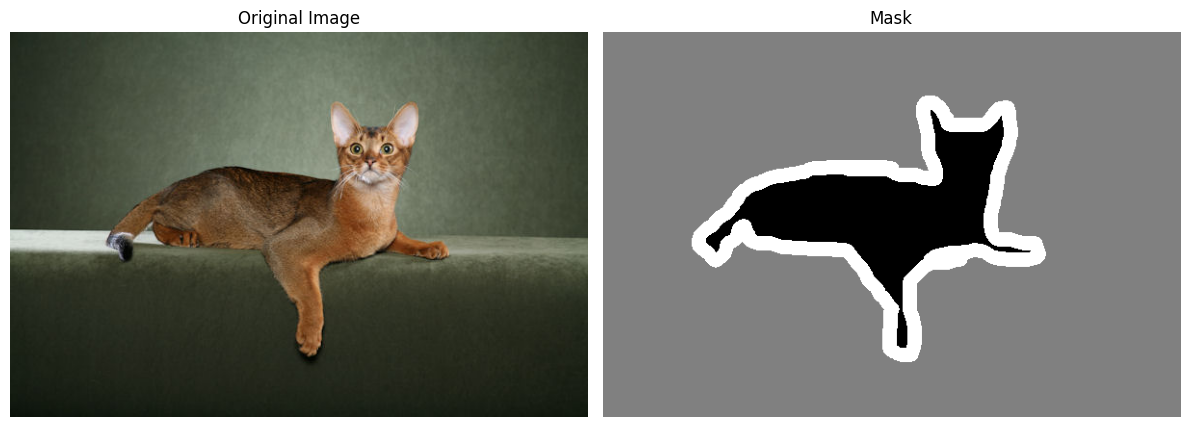

In [24]:
image_path = "images/Abyssinian_1.jpg"
mask_path = "annotations/trimaps/Abyssinian_1.png"

img = plt.imread(image_path)
mask = plt.imread(mask_path)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].imshow(img)
axs[0].axis('off')  # Turn off axis
axs[0].set_title("Original Image")

# Display the mask
axs[1].imshow(mask, cmap='gray')  # Use cmap='gray' if the mask is grayscale
axs[1].axis('off')  # Turn off axis
axs[1].set_title("Mask")

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [25]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [26]:
from tensorflow import keras
import numpy as np

In [27]:
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size


    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y

In [28]:
from tensorflow.keras import layers

In [29]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(x)
    return x

In [30]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [31]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [32]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [33]:
keras.backend.clear_session()
model = get_model(img_size, num_classes)

In [34]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:

import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("unet.keras", save_best_only=True)]
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen,callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 163s 525ms/step - loss: 48918.8008 - val_loss: 0.9240
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 89s 444ms/step - loss: 0.9169 - val_loss: 0.8877
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - loss: 0.8963 - val_loss: 0.8822
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 139s 452ms/step - loss: 0.8856 - val_loss: 0.8707
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 452ms/step - loss: 0.8638 - val_loss: 0.8016
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 90s 447ms/step - loss: 0.8576 - val_loss: 0.7397
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 147s 473ms/step - loss: 0.7468 - val_loss: 0.6369
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 96s 480ms/step - loss: 0.6655 - val_loss: 0.6003
Epoch 9/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 96s 479ms/step - loss: 0.6006 - val_loss: 0.5300
Epoch 10/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 90s 446ms/step - loss: 0.5624 - val_loss: 0.5314
Epoch 11/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 95s 473ms/step - loss: 0.5302 - val_loss: 0.4523
Epoch 12/15
199/199 ━